In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os


In [2]:
DATA_DIR = "/Users/timberzhang/Documents/Documents/2024-JustWatch/Data"
FILL_NAN = np.nan
CLUSTER_MIN_EPS = 25
CLUSTER_MIN_SAMPLE = 5

VR_SCALE = 0.001207812
VR_ZDIST = 1
EYE_SAMPLE_RATE = 50
EYE_SAMPLE_TIME = (1 / EYE_SAMPLE_RATE) * 1000
SCREEN_SIZE = [1280, 720]

VIDEO_SIZE = [1920, 1080]
VIDEO_FPS = 30
BALL_TRAJ = None

In [3]:

def fetch_eye_data(_raw_eye_data:str):
    _eye_data_rows = _raw_eye_data.split(";")
    eye_data = {}   
    names = _eye_data_rows[0].split(" ")
    for idx, row in enumerate(_eye_data_rows):
        if idx == 0 : continue

        cur_data = row.split(" ")
        try:
            eye_data[idx] = {
                names[0] : FILL_NAN if cur_data[0]=="NaN" else float(cur_data[0]),
                names[1] : FILL_NAN if cur_data[0]=="NaN" else float(cur_data[1]),
                names[2] : FILL_NAN if cur_data[0]=="NaN" else float(cur_data[2]),
                names[3] : FILL_NAN if cur_data[0]=="NaN" else float(cur_data[3]),
            }
        except:
            eye_data[idx] = {
                names[0] : FILL_NAN,
                names[1] : FILL_NAN,
                names[2] : FILL_NAN,
                names[3] : FILL_NAN,
            }

    return eye_data


In [4]:

def fetch_trajectory(dir_path:str):
    res = {}

    p_traj = pd.read_csv(os.path.join(dir_path, "pingpang.csv"))
    w_traj = pd.read_csv(os.path.join(dir_path, "tennis.csv"))
    _temp_all = pd.concat([p_traj, w_traj], axis=0)
    _temp_all["position"] = _temp_all["position"].apply(lambda x : x.replace(" ", ""))

    for v_id, v_df in _temp_all.groupby(by="video_name"):

        _x = v_df["position"].apply(lambda x : x.split(",")[0][1:]).to_numpy(dtype=np.int16)
        _y = v_df["position"].apply(lambda x : x.split(",")[1][:-1]).to_numpy(dtype=np.int16)

        # reverse the y-axis
        _y = (_y - VIDEO_SIZE[1]) * -1

        # scale and shift
        _x = (_x / VIDEO_SIZE[0]) * SCREEN_SIZE[0] - (SCREEN_SIZE[0] // 2)
        _y = (_y / VIDEO_SIZE[1]) * SCREEN_SIZE[1] - (SCREEN_SIZE[1] // 2)

        _f = v_df["frame_number"].to_numpy(dtype=np.int16)
        _r = v_df["round"].to_numpy(dtype=np.int16)
        _temp_df = pd.DataFrame(
            np.array([_f, _x, _y, _r]),
        ).T
        _temp_df.index = range(1, _f.size+1)
        _temp_df.columns = ["frame", "Ball.x", "Ball.y", "round"]

        res[v_id] = _temp_df.to_dict()

    return res

In [5]:
def interplate_and_align(base_df:pd.DataFrame, align_df:pd.DataFrame, base_rate:int, align_rate:int, convert_dist=False):
    share_rate = abs(base_rate * align_rate) // np.gcd(base_rate, align_rate)
    
    align_df["frame"] = align_df["frame"] * (share_rate // align_rate)
    temp_index= np.array(range(1, int(base_df["frame"].max()+1) * (share_rate // base_rate)))

    temp_time_df = pd.DataFrame(temp_index, index=temp_index, columns=["frame"])
    _index = temp_time_df.index
    temp_time_df = temp_time_df.merge(align_df, how="left", on="frame")
    temp_time_df.index = _index
    ## interplate
    for col in temp_time_df.columns:
        if col=="round": continue
        temp_time_df[col] = temp_time_df[col].interpolate(method='linear')
    ## ensure first row is not empty
    temp_time_df.ffill(inplace=True)
    temp_time_df.bfill(inplace=True)
    
    base_df["frame"] = base_df["frame"] * (share_rate // base_rate)
    _index = base_df.index
    alined_df = base_df.merge(temp_time_df, how="left", on="frame", )
    alined_df.index = _index
    alined_df["frame"] = alined_df["frame"] // (share_rate // base_rate)

    if convert_dist:
        alined_df = alined_df * VR_SCALE
        alined_df["frame"] = alined_df["frame"] // VR_SCALE

    alined_df.ffill(inplace=True)
    alined_df.bfill(inplace=True)

    return alined_df

In [6]:
## Timber
# data = pd.read_csv('Study22682754.csv')

## Patient
# data = pd.read_csv('Patients\\Study63104348.csv')

## Control
# data = pd.read_csv("/Users/timberzhang/Documents/Documents/2024-JustWatch/Data/24071008_AD.csv")
# data = pd.read_csv("/Users/timberzhang/Documents/Documents/2024-JustWatch/Data/Test_AD.csv")
data = pd.read_csv("/Users/timberzhang/Documents/Documents/2024-JustWatch/Data/24071512_AD.csv")
# data = pd.read_csv("/Users/timberzhang/Documents/Documents/2024-JustWatch/Data/24070904_AD.csv")



In [7]:
_single_person_data_dict = {}
_videos = {}

for _, row in data.iterrows():
    _eye_data = fetch_eye_data(row["EyeData"])
    v_id = row["videoName"]
    if v_id in _single_person_data_dict.keys(): 
        _videos[v_id] += 1
        v_id = v_id + f"_{_videos[v_id]}"
    else:
        _videos[v_id] = 1
    _single_person_data_dict[v_id] = _eye_data

In [8]:
print(_single_person_data_dict.keys())

dict_keys(['w12', 'w6', 'w18', 'w21', 'p7', 'p8', 'p19', 'p14', 'w20', 'w8', 'w12_2', 'w22', 'p10', 'p14_2', 'p7_2', 'p8_2', 'w20_A_S', 'w10_R_S', 'w16_R_S', 'w6_A_S', 'p8_A_S', 'p7_R_S', 'p5_R_S', 'p4_A_S', 'w20_R_S', 'w18_A_S', 'w10_A_S', 'w20_R_S_2', 'p8_R_S', 'p14_A_S', 'p2_A_S', 'p15_R_S', 'w10', 'w14', 'w17', 'w12_3', 'p19_2', 'p4', 'p7_3', 'p5', 'w12_A_A', 'w10_R_A', 'w16_R_A', 'w17_A_A', 'p2_A_A', 'p14_R_A', 'p10_R_A', 'p15_A_A'])


In [9]:
video_id = "p4"

In [10]:
BALL_TRAJ = fetch_trajectory(DATA_DIR)
ball_data = pd.DataFrame(BALL_TRAJ[video_id.split("_")[0]])

In [11]:
eye_data = pd.DataFrame(_single_person_data_dict[video_id]).T
eye_data.ffill(inplace=True)
eye_data.bfill(inplace=True)

In [12]:
eye_data["frame"] = eye_data.index
aligned_df = interplate_and_align(eye_data, ball_data, EYE_SAMPLE_RATE, VIDEO_FPS, convert_dist=False)

match_round = list(aligned_df["round"].value_counts(sort=False).index)

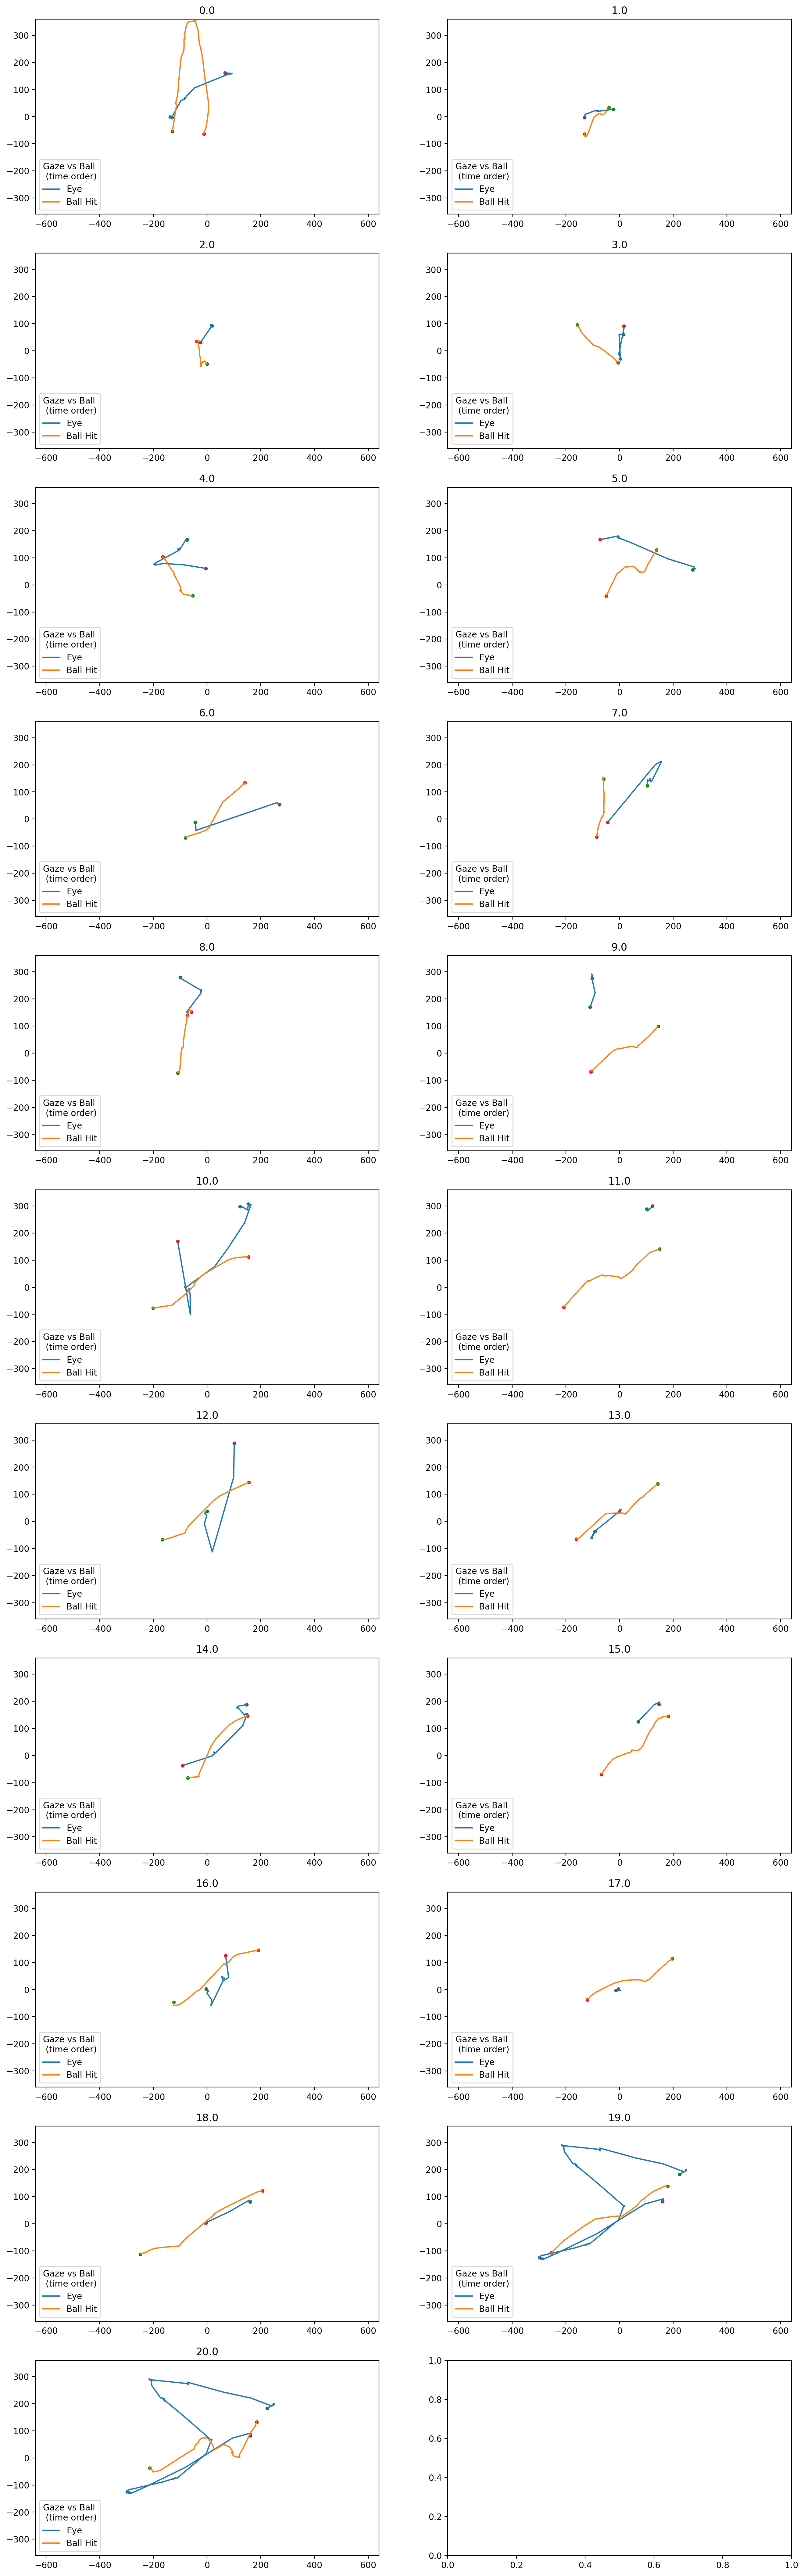

In [13]:
# plt.figure()
fig, ax=plt.subplots(nrows=int(np.ceil(len(match_round)/2)), ncols=2, figsize=(16,9*np.ceil(len(match_round)/4)), dpi=200)

for idx, (round) in enumerate(match_round):
    _row = idx // 2
    _col = idx % 2
    temp_ball = aligned_df[(aligned_df["round"]==round)]
    round_df = aligned_df[(aligned_df["round"]==round+1)]
    if round_df.shape[0]==0:
        round_df = aligned_df[(aligned_df["round"]==round)]
    if len(match_round)>2:
        ax[_row, _col].plot(round_df["Screen.x"], round_df["Screen.y"], label="Eye")
        ax[_row, _col].scatter(round_df.iloc[0, :]["Screen.x"], round_df.iloc[0, :]["Screen.y"], s=10, c="red")
        ax[_row, _col].scatter(round_df.iloc[-1, :]["Screen.x"], round_df.iloc[-1, :]["Screen.y"], s=10, c="green")

        # ax[_row, _col].plot(round_df["Ball.x"], round_df["Ball.y"], label="Ball Hit")
        ax[_row, _col].plot(temp_ball["Ball.x"], temp_ball["Ball.y"], label="Ball Hit")
        ax[_row, _col].scatter(temp_ball.iloc[0, :]["Ball.x"], temp_ball.iloc[0, :]["Ball.y"], s=10, c="red")
        ax[_row, _col].scatter(temp_ball.iloc[-1, :]["Ball.x"], temp_ball.iloc[-1, :]["Ball.y"], s=10, c="green")

        ax[_row, _col].legend( title="Gaze vs Ball\n (time order)", loc="lower left")
        ax[_row, _col].set_title( round )
        ax[_row, _col].set_xlim(-640,640)
        ax[_row, _col].set_ylim(-360,360)
    else:
        ax[_col].plot(round_df["Screen.x"], round_df["Screen.y"], label="Eye")
        ax[_col].scatter(round_df.iloc[0, :]["Screen.x"], round_df.iloc[0, :]["Screen.y"], s=10, c="red")
        ax[_col].scatter(round_df.iloc[-1, :]["Screen.x"], round_df.iloc[-1, :]["Screen.y"], s=10, c="green")

        # ax[_col].plot(round_df["Ball.x"], round_df["Ball.y"], label="Ball Hit")
        ax[_col].plot(temp_ball["Ball.x"], temp_ball["Ball.y"], label="Ball Hit")
        ax[_col].scatter(temp_ball.iloc[0, :]["Ball.x"], temp_ball.iloc[0, :]["Ball.y"], s=10, c="red")
        ax[_col].scatter(temp_ball.iloc[-1, :]["Ball.x"], temp_ball.iloc[-1, :]["Ball.y"], s=10, c="green")

        ax[_col].legend( title="Gaze vs Ball\n (time order)", loc="lower left")
        ax[_col].set_title( round )
        ax[_col].set_xlim(-640,640)
        ax[_col].set_ylim(-360,360)

plt.savefig(f"output/24071512_AD/{video_id}.png")